In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

# Chess games

- 100 players
- 2 groups (white and black)
- Can change groups 

In [13]:
N = 100
beta = 0.1
alpha = 1 
K = 20
p_ij = 1 / (1 + np.exp(-2*beta))

variance = 1 / np.sqrt(alpha * beta)
individual_scores = np.random.normal(0, variance, N)

theta = np.array([0.5, 0]) # white gets +0.5 advantage

groups_1 = np.random.randint(0, 2, N)
G_1 = np.zeros((N, 2))
for j, g_j in enumerate(groups_1):
    G_1[j, g_j] = 1
    
ranks_1 = individual_scores + np.matmul(G_1, theta)    
    
G_2 = np.abs(G_1 - 1)
ranks_2 = individual_scores + np.matmul(G_2, theta)

In [23]:
Z_1 = 0
Z_2 = 0
scaled_energy_1 = np.zeros((N, N))
scaled_energy_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        energy_1_ij = 0.5 * np.power(ranks_1[i] - ranks_1[j] - 1, 2)
        scaled_energy_1[i, j] =  np.exp(-beta * energy_1_ij)
        Z_1 += scaled_energy_1[i, j]
        
        energy_2_ij = 0.5 * np.power(ranks_2[i] - ranks_2[j] - 1, 2)
        scaled_energy_2[i, j] =  np.exp(-beta * energy_2_ij)
        Z_2 += scaled_energy_2[i, j]
c_1 = 20*N / Z_1
c_2 = 5*N / Z_2

A_1 = np.zeros((N, N))
A_2 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        if G_1[i, 0] == G_1[j, 1]:
            A_1[i, j] = np.random.poisson(c_1 * scaled_energy_1[i, j])
        if G_2[i, 0] == G_2[j, 1]:
            A_2[i, j] = np.random.poisson(c_2 * scaled_energy_2[i, j])

In [24]:
# Construct full operator with Laplacian

L1, d1 = tl.laplacian(A_1)
L2, d2 = tl.laplacian(A_2)

LHS_top1 = np.concatenate((L1, np.matmul(L1, G_1)), axis=1)
# LHS_top2 = np.concatenate((np.matmul(G_1.T, L1),
#                            np.matmul(G_1.T, np.matmul(L1, G_1))), axis=1)
# LHS_top = np.concatenate((LHS_top1, LHS_top2), axis=0)

LHS_bot1 = np.concatenate((L2, np.matmul(L2, G_2)), axis=1)
# LHS_bot2 = np.concatenate((np.matmul(G_2.T, L2),
#                            np.matmul(G_2.T, np.matmul(L2, G_2))), axis=1)
# LHS_bot = np.concatenate((LHS_bot1, LHS_bot2), axis=0)

LHS = np.concatenate((LHS_top1, LHS_bot1), axis=0)

# RHS_top = np.concatenate((d1, np.matmul(G_1.T, d1)), axis=0)
# RHS_bot = np.concatenate((d2, np.matmul(G_2.T, d2)), axis=0)
# RHS = np.concatenate((RHS_top, RHS_bot), axis=0)

RHS = np.concatenate((d1, d2), axis=0)

In [25]:
print(LHS.shape)
LA.matrix_rank(LHS)

(200, 102)


99

In [26]:
# Solve

result = LA.lstsq(LHS, RHS, rcond=None)
x = result[0]

a_est = x[:100]
theta_est = x[100:]

s_1 = a_est + np.matmul(G_1, theta_est)
s_2 = a_est + np.matmul(G_2, theta_est)

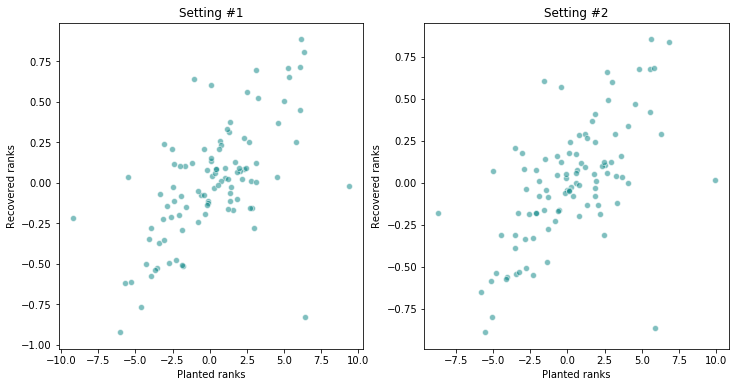

In [27]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(ranks_1, s_1, color="teal", edgecolor="white", alpha=0.5)
ax[0].set_xlabel("Planted ranks")
ax[0].set_ylabel("Recovered ranks")
ax[0].set_title("Setting #1")

ax[1].scatter(ranks_2, s_2, color="teal", edgecolor="white", alpha=0.5)
ax[1].set_xlabel("Planted ranks")
ax[1].set_ylabel("Recovered ranks")
ax[1].set_title("Setting #2")

plt.show()

In [28]:
theta_est - np.min(theta_est)

array([0.0334828, 0.       ])

In [45]:
a_1 = s_1 - np.matmul(G_1, theta_est)
a_2 = s_2 - np.matmul(G_2, theta_est)

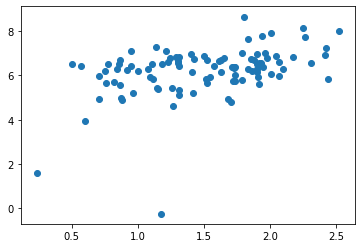

In [46]:
plt.scatter(a_1, a_2)